In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
csv_file_name = '/content/gdrive/MyDrive/HPC/formatted.csv'
dataset = pd.read_csv(csv_file_name)

dataset.head(500)

,time,car_7,car_9,car_15,car_18,car_20,car_22,car_59,car_60,car_88,car_98,car_1,car_3,car_4,car_6,car_10,car_12,car_13,car_14,car_17,car_19,car_21,car_23,car_24,car_25,car_26,car_27,car_28,car_30,car_33,car_64,car_66,car_29,car_32
0,2018-05-28 16:16:20,71.82,88.53,90.49,71.72,74.29,75.53,75.61,82.68,70.75,82.86,73.70,85.06,82.41,68.32,80.02,77.71,82.74,80.06,79.45,74.53,73.53,77.28,71.76,73.77,71.41,85.74,76.92,68.31,81.47,73.16,86.88,72.06,0.00
1,2018-05-28 16:16:21,70.66,86.96,91.91,70.19,74.02,75.11,73.14,83.83,70.99,80.67,73.55,84.86,84.30,68.52,77.98,76.88,84.50,82.63,85.52,76.69,72.75,78.72,70.90,73.53,73.99,88.10,74.66,67.03,83.75,74.08,85.84,72.96,0.00
2,2018-05-28 16:16:22,69.59,84.89,91.61,69.56,73.78,74.57,70.82,81.33,71.36,79.27,74.31,83.82,83.59,69.73,78.34,77.01,83.00,84.13,92.43,80.32,72.82,77.10,71.12,72.43,73.10,87.14,77.58,69.19,82.78,75.66,87.46,73.08,0.00
3,2018-05-28 16:16:23,68.92,82.83,87.44,72.29,73.29,75.30,70.88,83.90,72.49,77.76,76.09,79.91,83.24,70.37,76.00,75.63,81.74,84.69,97.97,77.07,72.58,77.51,73.17,72.37,70.93,84.78,79.43,70.69,80.85,73.22,85.87,70.93,0.00
4,2018-05-28 16:16:24,68.25,81.88,82.06,77.30,73.34,74.44,72.49,83.24,72.94,75.05,77.22,80.81,82.83,70.26,73.68,76.36,80.25,83.04,94.32,80.41,75.68,79.23,73.18,74.94,70.21,84.82,79.01,73.45,80.11,71.31,83.63,72.24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2018-05-28 16:24:35,203.37,212.33,221.88,215.21,220.83,215.98,216.29,209.40,224.13,216.73,210.07,211.98,236.94,229.49,202.86,205.57,227.71,212.33,199.85,227.68,213.22,233.14,219.55,224.30,208.33,214.84,222.52,229.66,226.20,221.90,205.50,228.80,233.03
496,2018-05-28 16:24:36,206.35,204.87,224.16,215.02,221.01,216.92,220.27,214.92,227.86,211.27,210.62,209.36,236.08,232.42,206.64,209.15,219.20,212.49,204.93,227.57,210.67,235.73,222.47,226.37,211.30,219.38,216.94,231.76,228.29,225.19,209.59,230.28,234.28
497,2018-05-28 16:24:37,211.79,204.78,226.86,215.41,221.42,217.25,224.30,218.05,231.12,208.20,210.98,208.57,219.42,230.44,211.95,210.49,211.57,214.54,209.37,199.20,211.01,232.41,225.55,228.09,214.03,223.36,216.49,231.63,228.47,227.61,214.14,231.84,235.20
498,2018-05-28 16:24:38,216.00,206.93,227.86,217.94,220.93,221.27,227.25,222.05,232.89,206.49,215.05,210.34,209.31,221.87,216.32,213.58,211.81,216.99,215.01,193.55,211.11,217.00,228.15,229.73,217.53,226.14,215.04,223.56,231.27,228.60,218.68,217.72,229.97


In [ ]:
comp_cars = ['car_12', 'car_20', 'car_9', 'car_27', 'car_28', 'car_22', 'car_29',
             'car_1', 'car_6', 'car_15', 'car_66', 'car_98', 'car_4', 'car_88',
             'car_25', 'car_60', 'car_64', 'car_23', 'car_19', 'car_21', 'car_17',
             'car_59', 'car_26', 'car_7', 'car_98']
print(len(comp_cars))

24


In [ ]:
dataset = dataset[comp_cars]
dataset.head()

,car_12,car_20,car_9,car_27,car_28,car_22,car_29,car_1,car_6,car_15,car_66,car_98,car_4,car_88,car_25,car_60,car_64,car_23,car_19,car_21,car_17,car_59,car_26,car_7
0,77.71,74.29,88.53,85.74,76.92,75.53,72.06,73.70,68.32,90.49,86.88,82.86,82.41,70.75,73.77,82.68,73.16,77.28,74.53,73.53,79.45,75.61,71.41,71.82
1,76.88,74.02,86.96,88.10,74.66,75.11,72.96,73.55,68.52,91.91,85.84,80.67,84.30,70.99,73.53,83.83,74.08,78.72,76.69,72.75,85.52,73.14,73.99,70.66
2,77.01,73.78,84.89,87.14,77.58,74.57,73.08,74.31,69.73,91.61,87.46,79.27,83.59,71.36,72.43,81.33,75.66,77.10,80.32,72.82,92.43,70.82,73.10,69.59
3,75.63,73.29,82.83,84.78,79.43,75.30,70.93,76.09,70.37,87.44,85.87,77.76,83.24,72.49,72.37,83.90,73.22,77.51,77.07,72.58,97.97,70.88,70.93,68.92
4,76.36,73.34,81.88,84.82,79.01,74.44,72.24,77.22,70.26,82.06,83.63,75.05,82.83,72.94,74.94,83.24,71.31,79.23,80.41,75.68,94.32,72.49,70.21,68.25


In [ ]:
print(dataset.max())

car_12    235.31
car_20    233.03
car_9     233.16
car_27    235.71
car_28    235.61
car_22    237.54
car_29    236.15
car_1     236.42
car_6     238.27
car_15    234.57
car_66    236.85
car_98    235.28
car_4     236.94
car_88    235.64
car_25    235.51
car_60    236.30
car_64    235.95
car_23    237.37
car_19    234.67
car_21    236.41
car_17    237.32
car_59    233.44
car_26    236.46
car_7     236.66
dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(np.expand_dims(dataset.car_12.values, 1))

In [ ]:
def create_dataset(X, time_steps=1):
  # reshape to [samples, time_steps, n_features]
    Xs, ys = [], []

    def single_col_dataset(X):
      for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(scaler.transform(np.expand_dims(v,1)))
        ys.append(scaler.transform(X[i+time_steps].reshape(1,1)))
        #ys.append(scaler.transform(np.expand_dims(X[i + 1: (i+ 1 + time_steps)],1)))

    if type(X) is pd.DataFrame:
      for col_name in (X.columns.values):
        car_data = X[col_name].values
        single_col_dataset(car_data)
    # if there is single column, we don't need two loops.
    else:
      single_col_dataset(X)

    return np.array(Xs), np.array(ys)[:,:,0]

In [ ]:
train_size = int(len(dataset) * 0.4)
val_size = int((len(dataset) * 0.1) + train_size)
print(train_size, val_size)

4505 5631


In [ ]:
time_step = 80
train_X, train_y = create_dataset(dataset.iloc[0:train_size], time_step)
val_X, val_y = create_dataset(dataset.iloc[train_size:val_size], time_step)
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

4505 5631
(106200, 80, 1) (106200, 1)
(25104, 80, 1) (25104, 1)


In [ ]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

(106200, 80, 1) (106200, 1)
(25104, 80, 1) (25104, 1)
(133248, 80, 1) (133248, 1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#train_X = torch.from_numpy(train_X).float().to(device)
#train_y = torch.from_numpy(train_y).float().to(device)
#train_X.device
train_data = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float())
val_data = TensorDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_y).float())
batch_size = 512
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)


NameError: ignored

In [ ]:
class LSTMNet(nn.Module):

    def __init__(self, input_dim, hidden_dim, seq_len, batch_size, num_layers=2):
        super(LSTMNet, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            dropout=0.5,
                            batch_first=True)
        self.linear = nn.Linear(in_features=hidden_dim, 
                                out_features=1) 

    def reset_hidden_state(self, batch_size):
        self.hidden = (
            torch.zeros(self.num_layers, batch_size, self.hidden_dim),
            torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        )   
        self.hidden = (self.hidden[0].to(device),
                       self.hidden[1].to(device))

    def forward(self, input):
        #lstm_out, self.hidden = self.lstm(
        #    input.view(len(input), self.seq_len, -1),
        #    self.hidden
        #)
        self.reset_hidden_state(len(input))
        #print("************FORWARD***********")
        lstm_out, self.hidden = self.lstm(input, self.hidden)
        #print("lstm_out shape: ", lstm_out.shape)
        #print("hidden shape: ", self.hidden.shape, self.hidden[0].shape, self.hidden[1].shape)


        #y_pred = self.linear(
        #    lstm_out.view(self.seq_len, len(input), self.hidden_dim)[-1]
        #)
        out = lstm_out.squeeze()[:,-1,:]
        #print("Out shape: ", out.shape)
        y_pred = self.linear(out) 
        #print("Y_pred shape: ", y_pred.shape)

        return y_pred



In [ ]:
# Here we define our model as a class
"""class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        print("****************")
        print(lstm_out.shape)
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)
"""

'class LSTM(nn.Module):\n \n    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,\n                    num_layers=2):\n        super(LSTM, self).__init__()\n        self.input_dim = input_dim\n        self.hidden_dim = hidden_dim\n        self.batch_size = batch_size\n        self.num_layers = num_layers\n \n        # Define the LSTM layer\n        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)\n \n        # Define the output layer\n        self.linear = nn.Linear(self.hidden_dim, output_dim)\n \n    def init_hidden(self):\n        # This is what we\'ll initialise our hidden state as\n        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),\n                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))\n \n    def forward(self, input):\n        # Forward pass through LSTM layer\n        # shape of lstm_out: [input_size, batch_size, hidden_dim]\n        # shape of self.hidden: (a, b), where a and b both \n

In [ ]:
# Here we define our model as a class
"""class LSTM1(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
"""

"class LSTM1(nn.Module):\n    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):\n        super(LSTM, self).__init__()\n        # Hidden dimensions\n        self.hidden_dim = hidden_dim\n\n        # Number of hidden layers\n        self.num_layers = num_layers\n\n        # Building your LSTM\n        # batch_first=True causes input/output tensors to be of shape\n        # (batch_dim, seq_dim, feature_dim)\n        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)\n\n        # Readout layer\n        self.fc = nn.Linear(hidden_dim, output_dim)\n\n    def forward(self, x):\n        # Initialize hidden state with zeros\n        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()\n\n        # Initialize cell state\n        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()\n\n        # One time step\n        # We need to detach as we are doing truncated backpropagation through time (BPTT)\n        

In [ ]:
def train_model(model, train_loader, val_loader, batch_size, time_step, test_data=None, test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='mean') #nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 50

    train_hist = np.zeros(num_epochs)
    val_hist = np.zeros(num_epochs)
    #test_hist = np.zeros(num_epochs)

    #batch_size = len(train_data)

    #model.reset_hidden_state(batch_size)

    valid_loss_min = np.Inf

    for t in range(num_epochs):
        print("Training Epoch: ", t)
        train_loss = []
        for input, labels in train_loader:
            model.zero_grad()
            input, labels = input.to(device), labels.to(device)
            y_pred = model(input)
            #print("Train Model fn:")
            #print(y_pred.shape, labels.shape)
            #print("$$$$$$$$$$$")

            loss = loss_fn(y_pred.float(), labels)
            train_loss.append(loss.item())
            #if t % 10 == 0:
            #print(f'Epoch {t} train loss: {loss.item()}')

            #train_hist[t] = loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        val_loss = []
        model.eval()
        for v_input, v_labels in val_loader:
            v_input, v_labels = v_input.to(device), v_labels.to(device)
            pred = model(v_input)
            v_loss = loss_fn(pred.float(), v_labels)
            val_loss.append(v_loss.item())
        model.train()



        train_hist[t] = np.mean(train_loss)
        print(f'Epoch {t} train loss: {train_hist[t]}')
        val_hist[t] = np.mean(val_loss)
        print(f'Epoch {t} val loss: {val_hist[t]}')

        if np.mean(val_loss) <= valid_loss_min:
        #     torch.save(model.state_dict(), '/content/gdrive/MyDrive/HPC/saved_model.pt')
          m = 'saved_model_' + str(time_step) +'.h5'
          torch.save(model, '/content/gdrive/MyDrive/HPC/'+m)
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_loss)))
        #     valid_loss_min = np.mean(val_loss)
        
    # m = 'saved_model_' + str(time_step) +'.h5'
    # torch.save(model, '/content/gdrive/MyDrive/HPC/'+m)
    # print('Model saved')
        
    return model.eval(), train_hist, val_hist

In [ ]:
#model = LSTM(1, 40, time_step, 1, 2)
#batch_size = 400
model = LSTMNet(1, 128, seq_len=time_step, batch_size=batch_size, num_layers=2)
model.to(device)
print(model)
#from torchsummary import summary
#model.reset_hidden_state()
#summary(model, input_size=()

LSTMNet(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
model, train_hist, val_hist = train_model(model, train_loader, val_loader, batch_size, time_step)

Training Epoch:  0
Epoch 0 train loss: 0.03071572306547679
Epoch 0 val loss: 0.006404031483132554
Validation loss decreased (inf --> 0.006404).  Saving model ...
Training Epoch:  1
Epoch 1 train loss: 0.005564418598534722
Epoch 1 val loss: 0.00414294136799467
Validation loss decreased (inf --> 0.004143).  Saving model ...
Training Epoch:  2
Epoch 2 train loss: 0.004583178622209851
Epoch 2 val loss: 0.0046689835498514385
Validation loss decreased (inf --> 0.004669).  Saving model ...
Training Epoch:  3
Epoch 3 train loss: 0.003804349759365341
Epoch 3 val loss: 0.004726686504790964
Validation loss decreased (inf --> 0.004727).  Saving model ...
Training Epoch:  4
Epoch 4 train loss: 0.003422057553703495
Epoch 4 val loss: 0.0028364282422800265
Validation loss decreased (inf --> 0.002836).  Saving model ...
Training Epoch:  5
Epoch 5 train loss: 0.0030090817967635196
Epoch 5 val loss: 0.0026472765198179886
Validation loss decreased (inf --> 0.002647).  Saving model ...
Training Epoch:  6
E

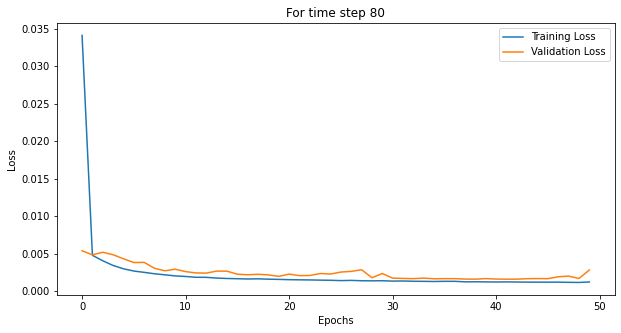

In [ ]:
# TIME STEP 80
import matplotlib.pyplot as plt
plt.figure(figsize=[10,5])
plt.plot(train_hist)
plt.plot(val_hist)
plt.title('For time step '+str(time_step))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

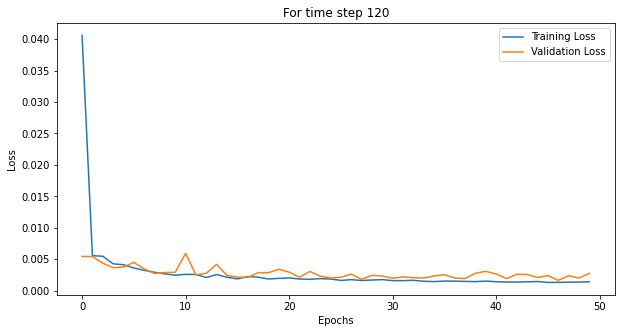

In [ ]:
# TIME STEP 120
import matplotlib.pyplot as plt
plt.figure(figsize=[10,5])
plt.plot(train_hist)
plt.plot(val_hist)
plt.title('For time step '+str(time_step))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

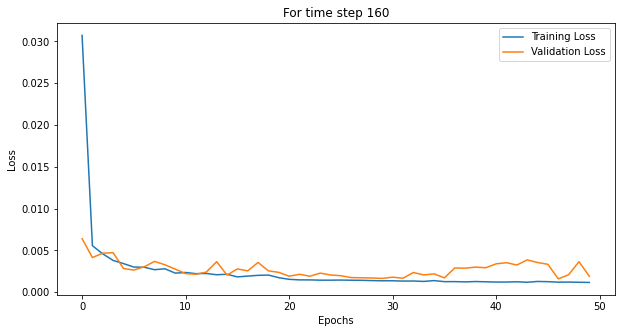

In [ ]:
# TIME STEP 160
import matplotlib.pyplot as plt
plt.figure(figsize=[10,5])
plt.plot(train_hist)
plt.plot(val_hist)
plt.title('For time step '+str(time_step))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
# winner_X, winner_y = create_dataset(dataset['car_12'], time_steps=time_step)

# winner_X = torch.from_numpy(winner_X).float().to(device)
# winner_y = torch.from_numpy(winner_y).float().to(device)

In [ ]:
# print(winner_X.shape)
# print(winner_X[0].T)
# print(winner_y.shape)
# print(winner_y[0])

In [ ]:
# Loading the model
# model.load_state_dict(torch.load('./saved_model.pt', map_location=device))
#model = torch.load('/content/gdrive/MyDrive/HPC/saved_model_80.h5', map_location=device)
#model = torch.load('/content/gdrive/MyDrive/HPC/saved_model_120.h5', map_location=device)
model = torch.load('/content/gdrive/MyDrive/HPC/saved_model_160.h5', map_location=device)

In [ ]:
test_size = len(dataset) - train_size - val_size
# print(test_size)
time_step = 160 
batch_size = 512
test_X, test_y = create_dataset(dataset.iloc[val_size:len(dataset)], time_step)
# print(test_X.shape, test_y.shape)
test_data = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).float())
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
i = 0
prediction, pred, r, m = [], [], [], []
with torch.no_grad():
  for x, y in test_loader:
    # print(x.shape, y.shape)
    i+=1
    # print(i)
    if torch.cuda.is_available():
      #if i >= 254: print(1)
      x, y = x.to(device), y.to(device)
      #model.reset_hidden_state(len(winner_X))
      #if i >= 254: print(2)
      pred = model(x)
      #prediction = prediction.float()
    # if i >= 254: print(3)
    prediction.extend(pred.tolist())
    # #prediction = predi.cpu()
    # if i >= 254: print(4)
    # winner_y = y#.cpu()
    # if i >= 254: print(5)
    rmse = torch.sqrt(torch.sum((pred - y)**2)/len(pred)).cpu().numpy()
    # if i >= 254: print(6)
    mse = (torch.sum((pred - y)**2)/len(pred)).cpu().numpy()
    # if i >= 254: print(7)
    # # print(rmse, mse)
    r.append(rmse)
    m.append(mse)
    # if i >= 254: print(8)
print(np.mean(r), np.mean(m))

0.03443111 0.0021807512


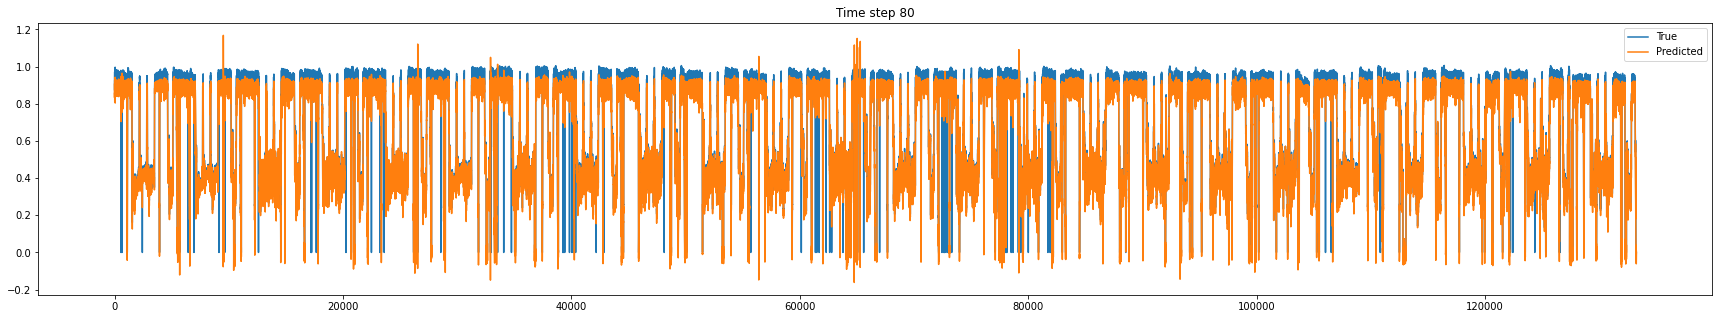

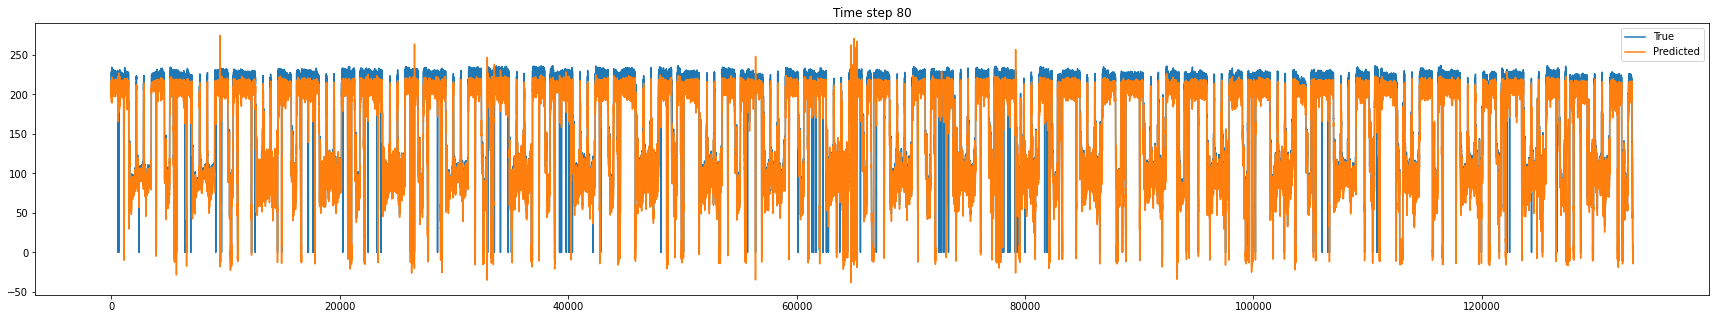

In [ ]:
# 0.043700837 0.0023086974
# TIME STEP 80
plt.figure(figsize=[30, 5])
plt.plot(test_y)
plt.plot(prediction)
plt.title('Time step '+str(time_step))
plt.legend(['True', 'Predicted'])
plt.show()

plt.figure(figsize=[30,5])
plt.plot(scaler.inverse_transform(test_y))
plt.plot(scaler.inverse_transform(prediction))
plt.legend(['True', 'Predicted'])
plt.title('Time step '+str(time_step))
plt.show()

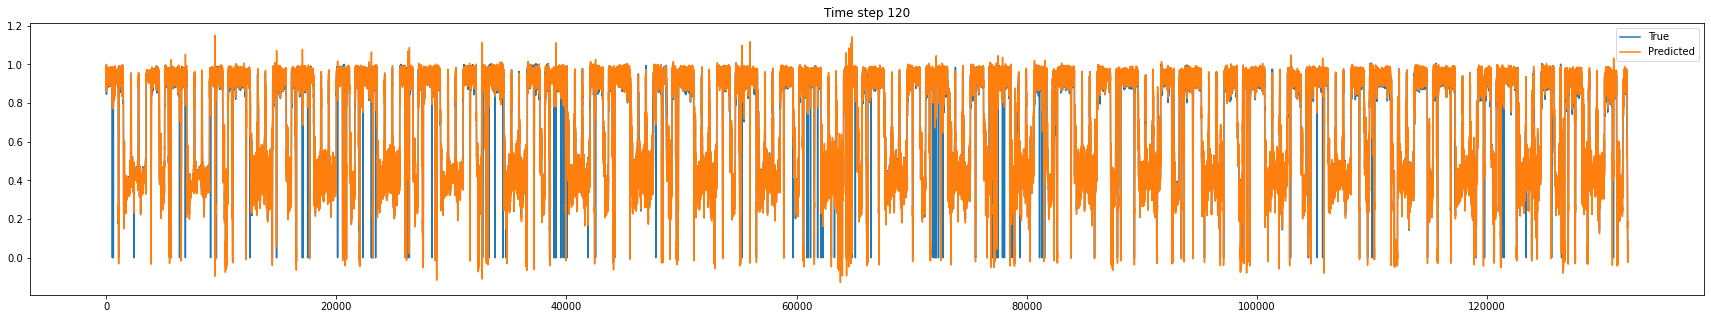

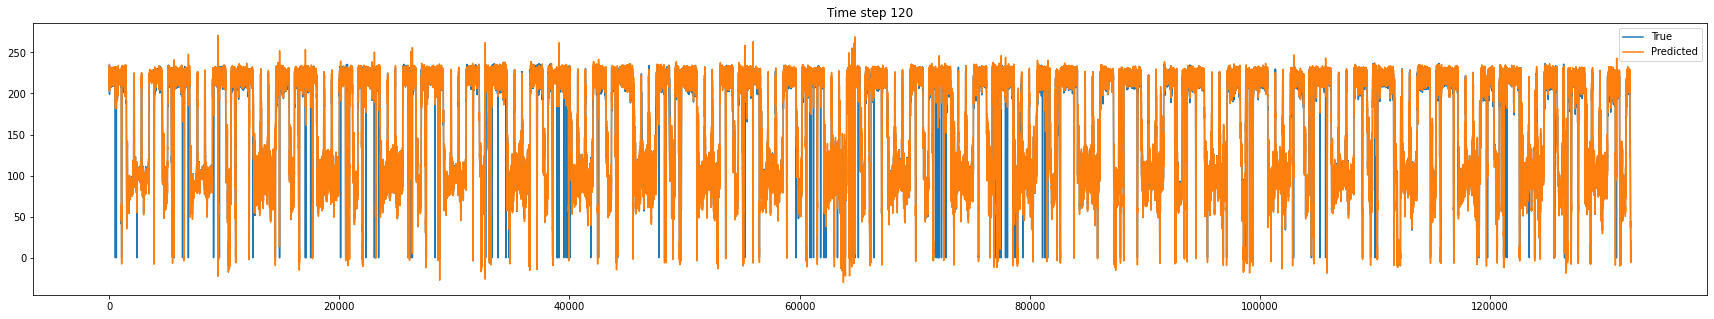

In [ ]:
0.037596565 0.00308338
# TIME STEP 120
plt.figure(figsize=[30, 5])
plt.plot(test_y)
plt.plot(prediction)
plt.title('Time step '+str(time_step))
plt.legend(['True', 'Predicted'])
plt.show()

plt.figure(figsize=[30,5])
plt.plot(scaler.inverse_transform(test_y))
plt.plot(scaler.inverse_transform(prediction))
plt.legend(['True', 'Predicted'])
plt.title('Time step '+str(time_step))
plt.show()

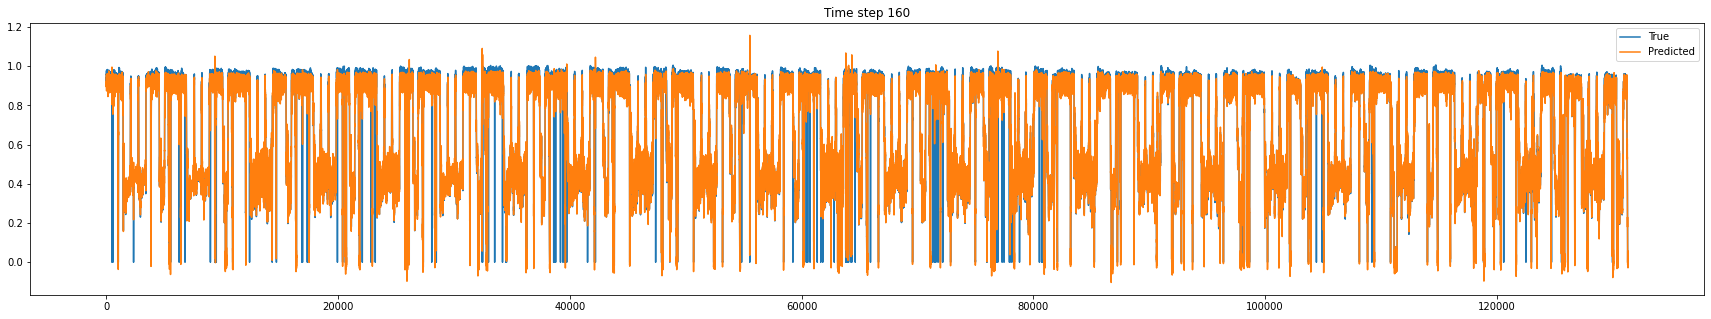

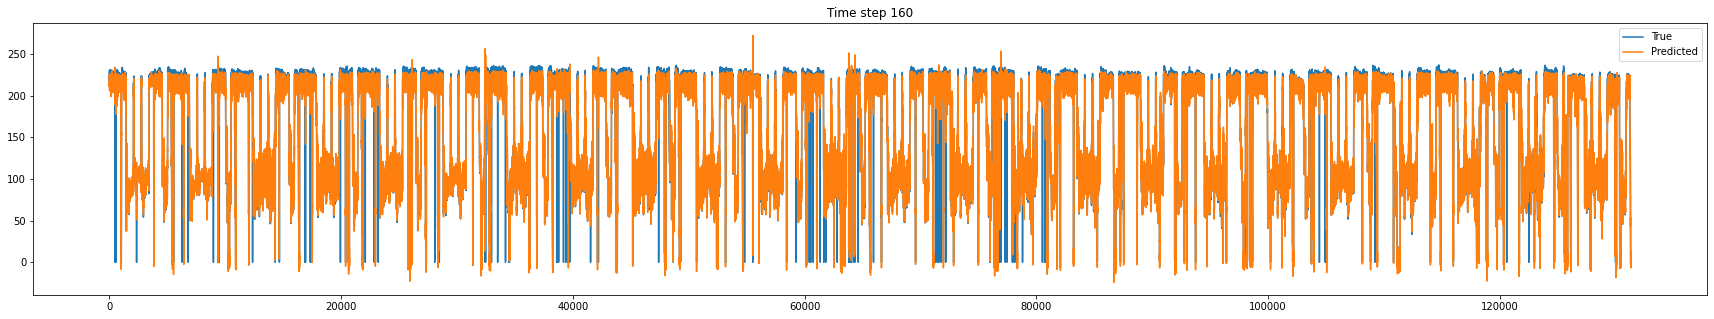

In [ ]:
0.03443111 0.0021807512
# TIME STEP 160
plt.figure(figsize=[30, 5])
plt.plot(test_y)
plt.plot(prediction)
plt.title('Time step '+str(time_step))
plt.legend(['True', 'Predicted'])
plt.show()

plt.figure(figsize=[30,5])
plt.plot(scaler.inverse_transform(test_y))
plt.plot(scaler.inverse_transform(prediction))
plt.legend(['True', 'Predicted'])
plt.title('Time step '+str(time_step))
plt.show()

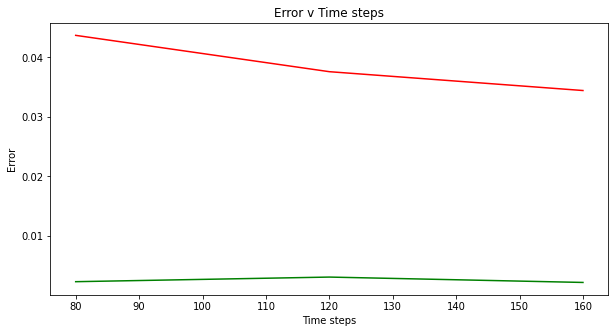

In [ ]:
import matplotlib.pyplot as plt
rmse_c = [0.043700837, 0.037596565, 0.03443111]
mse_c = [0.0023086974, 0.00308338, 0.0021807512]
ts = [80, 120, 160]

plt.figure(figsize=(10,5))
plt.plot(ts, rmse_c, color='red', label='RMSE')
plt.plot(ts, mse_c, color='green', label='MSE')
plt.title('Error v Time steps')
plt.xlabel('Time steps')
plt.ylabel('Error')
plt.show()

In [ ]:
rmse = torch.sqrt(torch.sum((prediction - torch.Tensor(test_y))**2)/len(prediction))
mse = torch.sum((prediction - torch.Tensor(test_y))**2)/len(prediction)
print(rmse.cpu().numpy(), mse.cpu().numpy())

0.03427432 0.0011747292


In [ ]:
loss = np.abs(prediction[:,0] - winner_y[:,0])

anomaly_result = np.zeros(len(loss))
threshold = 0.045

anomaly_result[loss > threshold] = 1
#np.count_nonzero(anomaly_result)
print(len(loss), np.count_nonzero(anomaly_result))

133248 2171


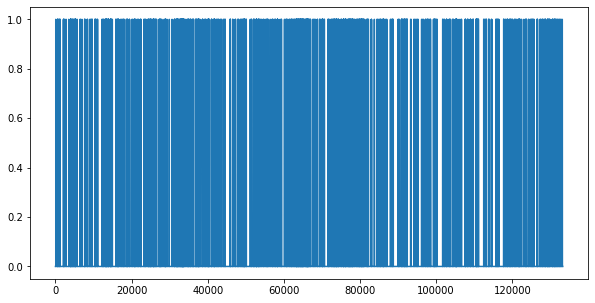

In [ ]:
plt.figure(figsize=[10,5])
plt.plot(anomaly_result)
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
plt.plot(scaler.inverse_transform(prediction))
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              anomaly_result[np.newaxis],
              cmap='Reds', alpha=0.5)